In [1]:
import xarray 
import os 
store_dir = os.environ['STORE']
scratch_dir = os.environ['SCRATCH']
import xmip
import numpy as np
import rioxarray


def replace_x_y_nominal_lat_lon(ds):
    """Approximate the dimensional values of x and y with mean lat and lon at the equator"""
    ds = ds.copy()
    
    def maybe_fix_non_unique(data, pad=False):
        """remove duplicate values by linear interpolation
        if values are non-unique. `pad` if the last two points are the same
        pad with -90 or 90. This is only applicable to lat values"""
        if len(data) == len(np.unique(data)):
            print('no pad')
            return data
        else:
            # pad each end with the other end.
            if pad:
                if len(np.unique([data[0:2]])) < 2:
                    data[0] = -90
                if len(np.unique([data[-2:]])) < 2:
                    data[-1] = 90

            ii_range = np.arange(len(data))
            _, indicies = np.unique(data, return_index=True)
            double_idx = np.array([ii not in indicies for ii in ii_range])
            # print(f"non-unique values found at:{ii_range[double_idx]})")
            data[double_idx] = np.interp(
                ii_range[double_idx], ii_range[~double_idx], data[~double_idx]
            )
            
            return data

    if "x" in ds.dims and "y" in ds.dims:
        # define 'nominal' longitude/latitude values
        # latitude is defined as the max value of `lat` in the zonal direction
        # longitude is taken from the `middle` of the meridonal direction, to
        # get values close to the equator

        # pick the nominal lon/lat values from the eastern
        # and southern edge, and
        eq_idx = len(ds.y) // 2

        nominal_x = ds.isel(y=eq_idx).lon.load()
        nominal_y = ds.lat.max("x").load()
        # interpolate nans
        # Special treatment for gaps in longitude
        # nominal_x = _interp_nominal_lon_new(nominal_x.data)
        nominal_x = nominal_x.interpolate_na("x").data
        nominal_y = nominal_y.interpolate_na("y").data
        # nominal_x = nominal_x - 0.5
        # print(nominal_x)
        # eliminate non unique values
        # these occour e.g. in "MPI-ESM1-2-HR"
        # nominal_y = maybe_fix_non_unique(nominal_y)
        # nominal_x = maybe_fix_non_unique(nominal_x)
        # ds['tos'].isel(time=0).plot()
        # print(ds.x)
        # print(len(ds.x))
        # print(len(nominal_x))
        ds = ds.assign_coords(x=nominal_x, y=nominal_y)
        ds = ds.sortby("x")
        ds = ds.sortby("y")

        # do one more interpolation for the x values, in case the boundary values were
        # affected
        ds = ds.assign_coords(
            x=maybe_fix_non_unique(ds.x.load().data,pad=False),
            y=maybe_fix_non_unique(ds.y.load().data, pad=True),
        )
    else:
        warnings.warn(
            "No x and y found in dimensions for source_id:%s. This likely means that you forgot to rename the dataset or this is the German unstructured model"
            % ds.attrs["source_id"]
        )
    return ds



In [2]:
   
year = 1961
variation = 1
# Lmon =  xarray.open_mfdataset(f'{store_dir}/s{year}-r{variation}i1p1f1/Lmon/*.nc',compat='minimal')
Amon =  xarray.open_mfdataset(f'{store_dir}/s{year}-r{variation}i1p1f1/Amon/*.nc',compat='minimal')
#  Emon =  xarray.open_mfdataset(f'{store_dir}/s{year}-r{variation}i1p1f1/Emon/*.nc',compat='override')
Omon =  xarray.open_mfdataset(f'{store_dir}/s{year}-r{variation}i1p1f1/Omon/*.nc',compat='minimal')

#  Lmon = Lmon.drop_vars(['time_bounds','depth_bounds','sector','depth'])
#  Amon = Amon.drop_vars(['time_bounds'])
# Emon = Emon.drop_vars(['height','depth','tdps','ppdiat','ppmisc','expfe','olevel_bounds','olevel','flandice','t20d','thetaot','thetaot2000','thetaot300','thetaot700','bounds_nav_lat','bounds_nav_lon','lev','area','type'])
# Emon = Emon.drop_dims(['landuse','x','y','axis_nbounds'])
Omon = Omon.drop_dims(['nvertex'])
Omon = Omon.drop_vars(['area','time_bounds'])

#this is a mess.....
from xmip.preprocessing import promote_empty_dims, broadcast_lonlat
from xmip.preprocessing import rename_cmip6
from xmip.preprocessing import correct_units,correct_lon
from xmip.preprocessing import correct_coordinates,parse_lon_lat_bounds, maybe_convert_bounds_to_vertex, maybe_convert_vertex_to_bounds

def _interp_nominal_lon_new(lon_1d):
    print('Using altered version')
    x = np.arange(len(lon_1d))
    print(x)
    idx = np.isnan(lon_1d)
    # TODO assume that longitudes are cyclic (i.e., don't)
    ret = np.interp(x, x[~idx], lon_1d[~idx], period=len(lon_1d))
    return ret

# xmip.preprocessing._interp_nominal_lon = _interp_nominal_lon_new

ds = Omon.copy()
ds = rename_cmip6(ds)
ds = promote_empty_dims(ds)
ds = broadcast_lonlat(ds)
#ds.isel(time=0)['tos'].plot()
ds = replace_x_y_nominal_lat_lon(ds)
#ds.isel(time=0)['tos'].plot()
ds = correct_lon(ds)
ds = correct_coordinates(ds)
ds = parse_lon_lat_bounds(ds)
ds = maybe_convert_bounds_to_vertex(ds)
ds = maybe_convert_vertex_to_bounds(ds)

    
        

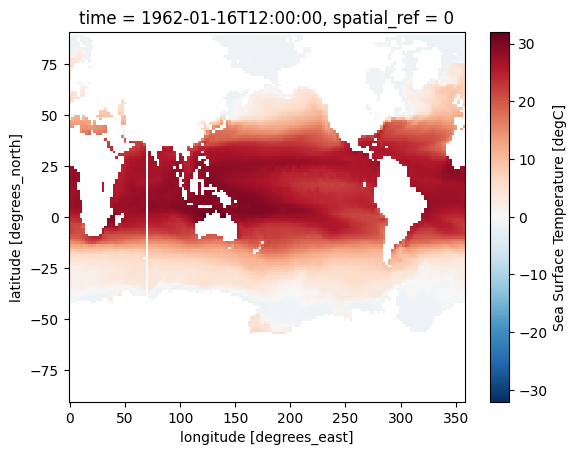

In [4]:
ds = ds.assign_coords({'x':ds.x-0.5})
ds.rio.set_spatial_dims('x', 'y', inplace=True)
ds.rio.write_crs("epsg:4326",inplace=True)
# Omon.rio.write_crs(4326,inplace=True)
Amon.rio.write_crs(4326,inplace=True)
ds.rio.set_spatial_dims('x', 'y', inplace=True)
ds = ds.drop_vars(['lat','lon'])
Omon_reproj = ds.rio.reproject_match(Amon)

Omon_reproj.isel(time=0)['tos'].plot()

In [9]:
Omon.isel(time=0)

<xarray.Dataset>
Dimensions:  (y: 332, x: 362)
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    time     datetime64[ns] 1962-01-16T12:00:00
Dimensions without coordinates: y, x
Data variables:
    tos      (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
Attributes: (12/51)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2019-03-28T21:11:08Z
    description:            A1 (and A2.1, A3.1, and A3.2) Decadal hindcasts b...
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / DC...
    activity_id:            DCPP
    contact:                ipsl-cmip6@listes.ipsl.fr
    ...                     ...
    branch_time_in_child:   0.0
    branch_time_in_parent:  22645.0
    sub_experiment:         initialized near end of year 1961
    tracking_id:            hdl:21.14100/6e355eb4-bfaa-482a-8e3c-2ebd822c4395
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    sub_experiment_id:      s1961